In [17]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"
df_raw = pd.read_csv(url, parse_dates=["date"], index_col="date")
df_raw = df_raw.asfreq("MS")  # Monthly Start frequency
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2022-10-01 17:10:08.079328 to 2023-09-01 17:10:08.079328
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   12 non-null     float64
dtypes: float64(1)
memory usage: 192.0 bytes


In [18]:
df_raw.head(12)

,sales
date,
2022-10-01 17:10:08.079328,127.475050
2022-11-01 17:10:08.079328,202.473420
2022-12-01 17:10:08.079328,284.807191
2023-01-01 17:10:08.079328,363.458044
2023-02-01 17:10:08.079328,448.153727
2023-03-01 17:10:08.079328,515.942848
2023-04-01 17:10:08.079328,599.305879
2023-05-01 17:10:08.079328,672.745223
2023-06-01 17:10:08.079328,747.024687


In [19]:
df = df_raw.copy()

Construye y analiza la serie temporal

Construye la estructura de datos válida para la serie temporal, grafícala y, a continuación, analízala y responde a las siguientes preguntas:

* ¿Cuál es el tensor de la serie temporal?
* ¿Cuál es la tendencia?
* ¿Es estacionaria?
* ¿Existe variabilidad o presencia de ruido?

<Axes: title={'center': 'Ventas Mensuales'}, xlabel='date'>

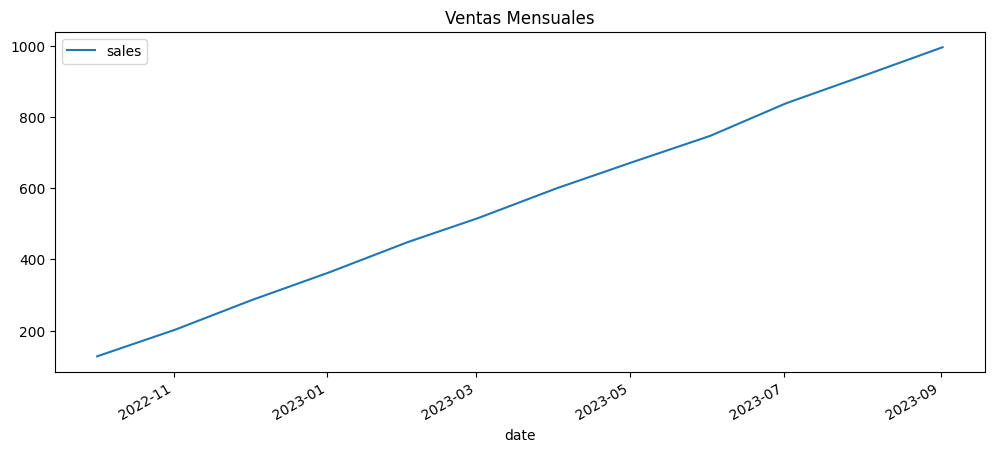

In [20]:
#tensor
df.plot(title="Ventas Mensuales", figsize=(12, 5))

<Axes: title={'center': 'Tendencia de Ventas'}, xlabel='date'>

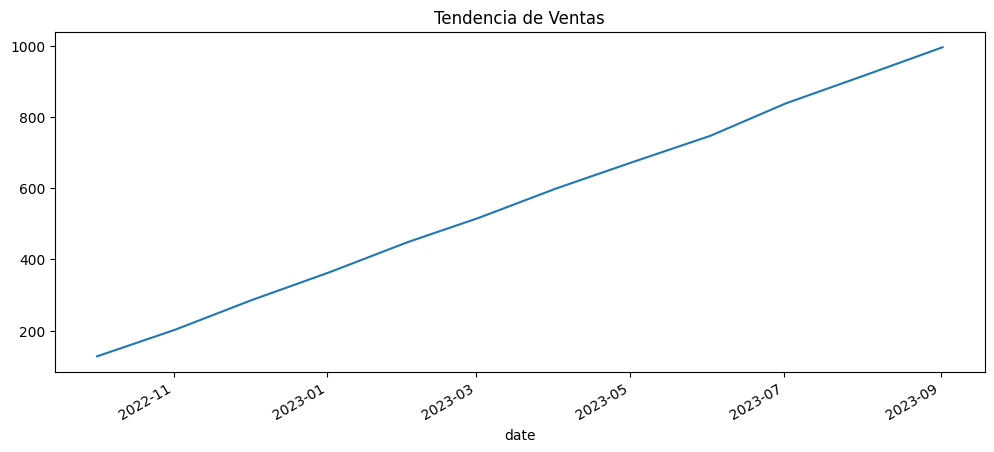

In [21]:
#Hallar la tendencia 
df["sales"].plot(title="Tendencia de Ventas", figsize=(12, 5))

In [22]:
# Verificar si es estacionaria
result = adfuller(df["sales"])
print("p-value:", result[1])

p-value: 0.9858010072349016


Si el p-value > 0.05, no se puede rechazar H₀ ⇒ la serie no es estacionaria.

In [23]:
# Diferencias si no es estacionaria
if result[1] > 0.05:
    df["sales_diff"] = df["sales"].diff()
    df = df.dropna(subset=["sales_diff"])

In [24]:
result_diff = adfuller(df["sales_diff"])
print("p-value (diferenciada):", result_diff[1])

p-value (diferenciada): 3.385915585887766e-05


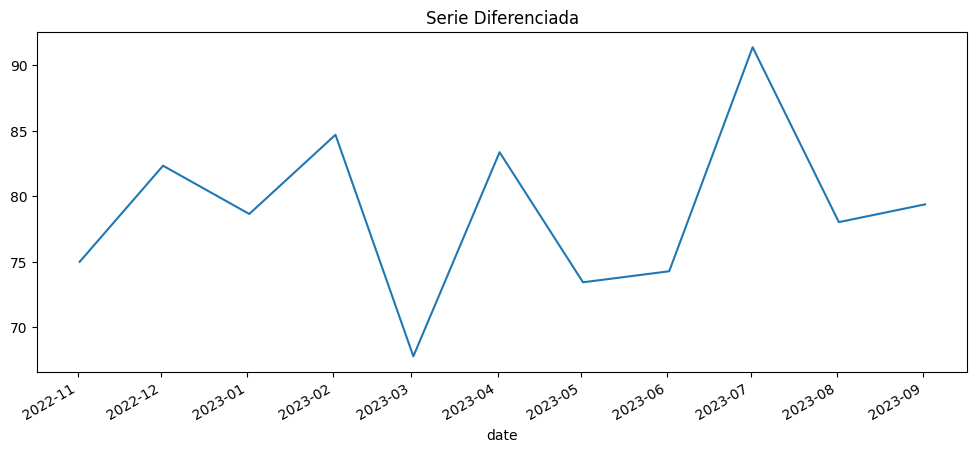

In [25]:
df["sales_diff"].plot(title="Serie Diferenciada", figsize=(12, 5))
plt.show()

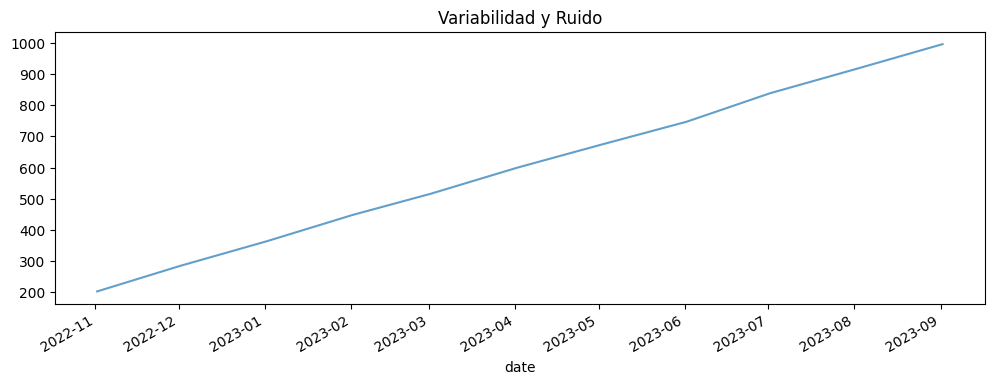

In [26]:
# Ruido y variabilidad
df["sales"].plot(figsize=(12, 4), alpha=0.7, title="Variabilidad y Ruido")
plt.show()

### Entrenar un ARIMA

In [27]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

In [28]:
# Dividir en train y test (últimos 12 meses como test)
train = df.iloc[:-12]["sales"]
test = df.iloc[-12:]["sales"]

In [29]:
try:
    model = ARIMA(df['sales'], order=(1,1,1))  # Ajusta el (p,d,q) si es necesario
    model_fit = model.fit()
    print(model_fit.summary())
except Exception as e:
    print("Error al ajustar el modelo ARIMA:", e)

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   11
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -36.713
Date:                Mon, 05 May 2025   AIC                             79.426
Time:                        22:43:40   BIC                             80.333
Sample:                    11-01-2022   HQIC                            78.430
                         - 09-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   2.63e-05    3.8e+04      0.000       1.000       1.000
ma.L1         -0.9923      0.482     -2.058      0.040      -1.938      -0.047
sigma2        44.1863      0.011   4128.538      0.0

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [30]:
## Paso 4: Predicciones
forecast = model_fit.forecast(steps=len(test))  # steps=11 ya que me salia error con 12
forecast.index = test.index 

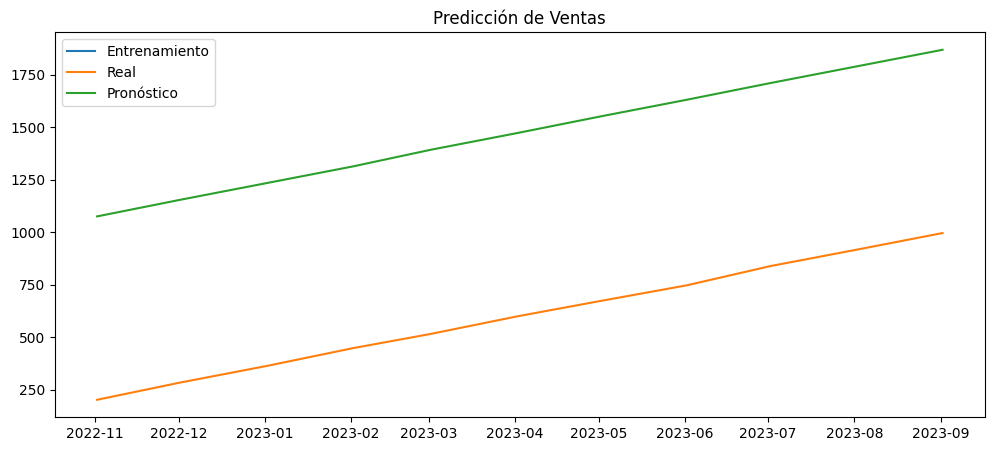

In [31]:
plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label="Entrenamiento")
plt.plot(test.index, test, label="Real")
plt.plot(forecast.index, forecast, label="Pronóstico")
plt.legend()
plt.title("Predicción de Ventas")
plt.show()

In [32]:
# Medir el rendimiento
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, forecast))
print("RMSE:", rmse)

RMSE: 872.9098981574718


## Guardar el modelo

In [33]:
import joblib
joblib.dump(model_fit, "/workspaces/Serie-temporal-Alternativa/models/best_model.pkl")

['/workspaces/Serie-temporal-Alternativa/models/best_model.pkl']